In [1]:
import time
notebookstart= time.time()

In [2]:
import os
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np

import cv2
#from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener() # for using Image.open for .heic without changes

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_TRAIN = os.path.join(os.getcwd(), 'subm', 'train')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [5]:
train_df = pd.read_csv(os.path.join(DIR_SUBM_TRAIN, 'train_with_pred.csv'))
train_df.shape

(527, 17)

In [6]:
def open_img(inp_path: str) -> np.ndarray:
    
    if inp_path.endswith('.jpg'):
        ret_img = cv2.imread(inp_path)
    else:
        if pillow_heif.is_supported(inp_path):
            heif_file = pillow_heif.open_heif(inp_path, convert_hdr_to_8bit=False)
            #print("image mode:", heif_file.mode)
            #print("image data length:", len(heif_file.data))
            #print("image data stride:", heif_file.stride)
            if heif_file.has_alpha:
                heif_file.convert_to("BGRA;16")
            else:
                heif_file.convert_to("BGR;16")  # convert 10 bit image to RGB 16 bit.
            #print("image mode:", heif_file.mode)
            ret_img = np.asarray(heif_file)
    
    return ret_img

In [7]:
def plot_corrc(inp_df, inp_cols, targ_cols = ['distance']):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(),
    #sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(), \n",
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'),
    #sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(), \n",
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
#    sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(method = 'spearman'), \n",
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 0])\n",
#    sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(method = 'spearman'), \n",
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 1])\n",
    if 'distrib_brdr' in inp_df.columns:
        sns.pairplot(inp_df[inp_cols + targ_cols + ['distrib_brdr']], height = 16,
                     hue = 'distrib_brdr', #palette = {\"A\": \"C0\", \"B\": \"C1\"}\n",
                     #markers = ['x', 'o']\n",
                    )
    else:
        sns.pairplot(inp_df[inp_cols + targ_cols], height = 16,
                    )
   

Рассчитаем и помотрим на ошибки

In [8]:
train_df['err'] = train_df.distance - train_df.pred
train_df['err_upd'] = train_df.err.apply(lambda x: abs(x))

<AxesSubplot:>

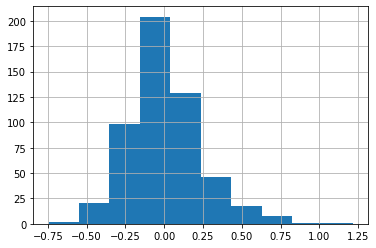

In [9]:
train_df.err.hist()

<AxesSubplot:>

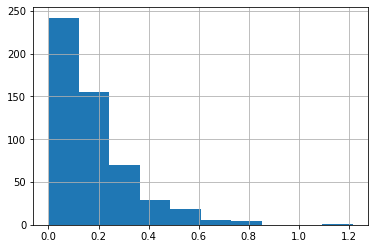

In [10]:
train_df.err_upd.hist()

In [11]:
train_df.err.nsmallest(5)

480   -0.745324
14    -0.695790
93    -0.546443
4     -0.534434
105   -0.530229
Name: err, dtype: float64

In [12]:
train_df.err.nlargest(5)

504    1.215665
55     0.831578
26     0.791649
510    0.761588
231    0.757692
Name: err, dtype: float64

In [13]:
train_df.sort_values(by='err_upd', ascending = False, inplace = True)

In [14]:
train_df.head(20)

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w,log_x_min,log_y_min,log_x_max,log_y_max,log_h,log_w,pred,err,err_upd
504,img_2903.jpg,4.33,1392.591064,1183.050781,2279.875977,1880.717041,0.933878,2.0,697.666260,887.284912,7.238921,7.075852,7.731876,7.539408,6.547741,6.788166,3.114335,1.215665,1.215665
55,img_1700.jpg,5.00,1549.456177,1298.457031,2224.695557,1900.568115,0.916365,2.0,602.111084,675.239380,7.345659,7.168932,7.707375,7.549908,6.400442,6.515067,4.168422,0.831578,0.831578
26,img_1643.jpg,5.49,1746.241333,1211.158936,2365.635498,1756.302979,0.927489,2.0,545.144043,619.394165,7.465221,7.099333,7.768802,7.470966,6.301050,6.428742,4.698351,0.791649,0.791649
510,img_2913.jpg,6.61,1659.580811,1239.323730,2132.031494,1629.814209,0.915593,2.0,390.490479,472.450684,7.414320,7.122321,7.664831,7.396221,5.967404,6.157933,5.848412,0.761588,0.761588
231,img_2289.jpg,7.55,2522.481201,1303.967773,3182.827637,1670.263184,0.922770,2.0,366.295410,660.346436,7.832998,7.173167,8.065525,7.420736,5.903440,6.492765,6.792308,0.757692,0.757692
480,img_2862.jpg,2.10,1383.951538,1250.134766,2192.228516,1865.447510,0.937753,2.0,615.312744,808.276978,7.232698,7.131007,7.692674,7.531256,6.422131,6.694905,2.845324,-0.745324,0.745324
61,img_1713.jpg,3.96,1600.428955,1105.802490,2383.656006,1739.076172,0.926868,2.0,633.273682,783.227051,7.378027,7.008327,7.776391,7.461109,6.450903,6.663423,3.249075,0.710925,0.710925
15,img_1621.jpg,7.37,1479.507080,1121.258911,2624.041016,2121.085449,0.887677,2.0,999.826538,1144.533936,7.299464,7.022207,7.872471,7.659683,6.907582,7.042753,6.667107,0.702893,0.702893
58,img_1709.jpg,7.17,1675.892456,1274.072876,2102.822021,1642.652222,0.921770,2.0,368.579346,426.929565,7.424101,7.149974,7.651036,7.404067,5.909656,6.056619,6.471115,0.698885,0.698885
14,img_1620.jpg,1.52,1318.738037,1117.455200,2259.474365,1940.945435,0.920690,2.0,823.490234,940.736328,7.184431,7.018809,7.722887,7.570930,6.713552,6.846663,2.215790,-0.695790,0.695790


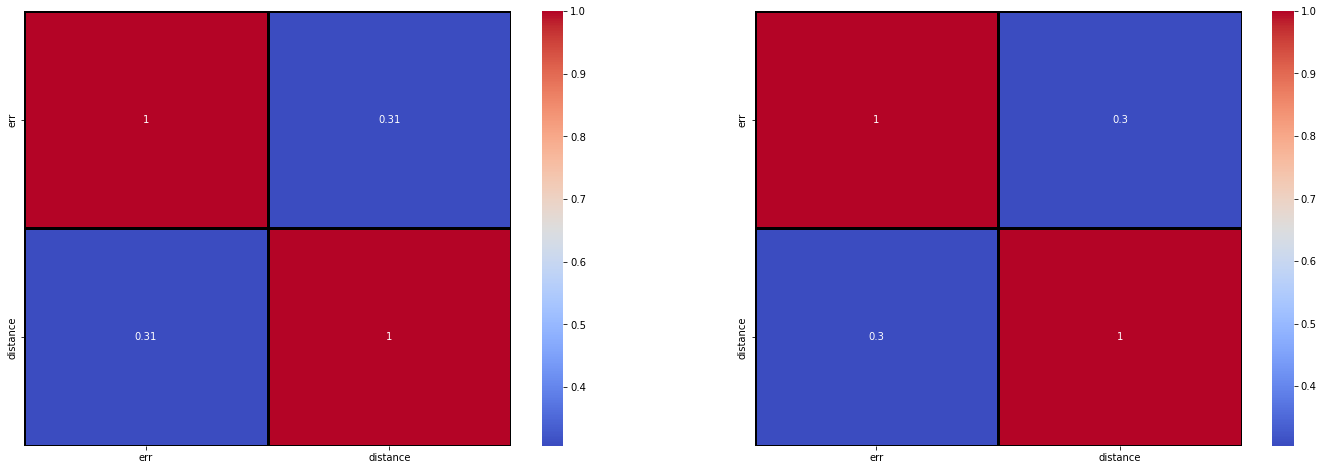

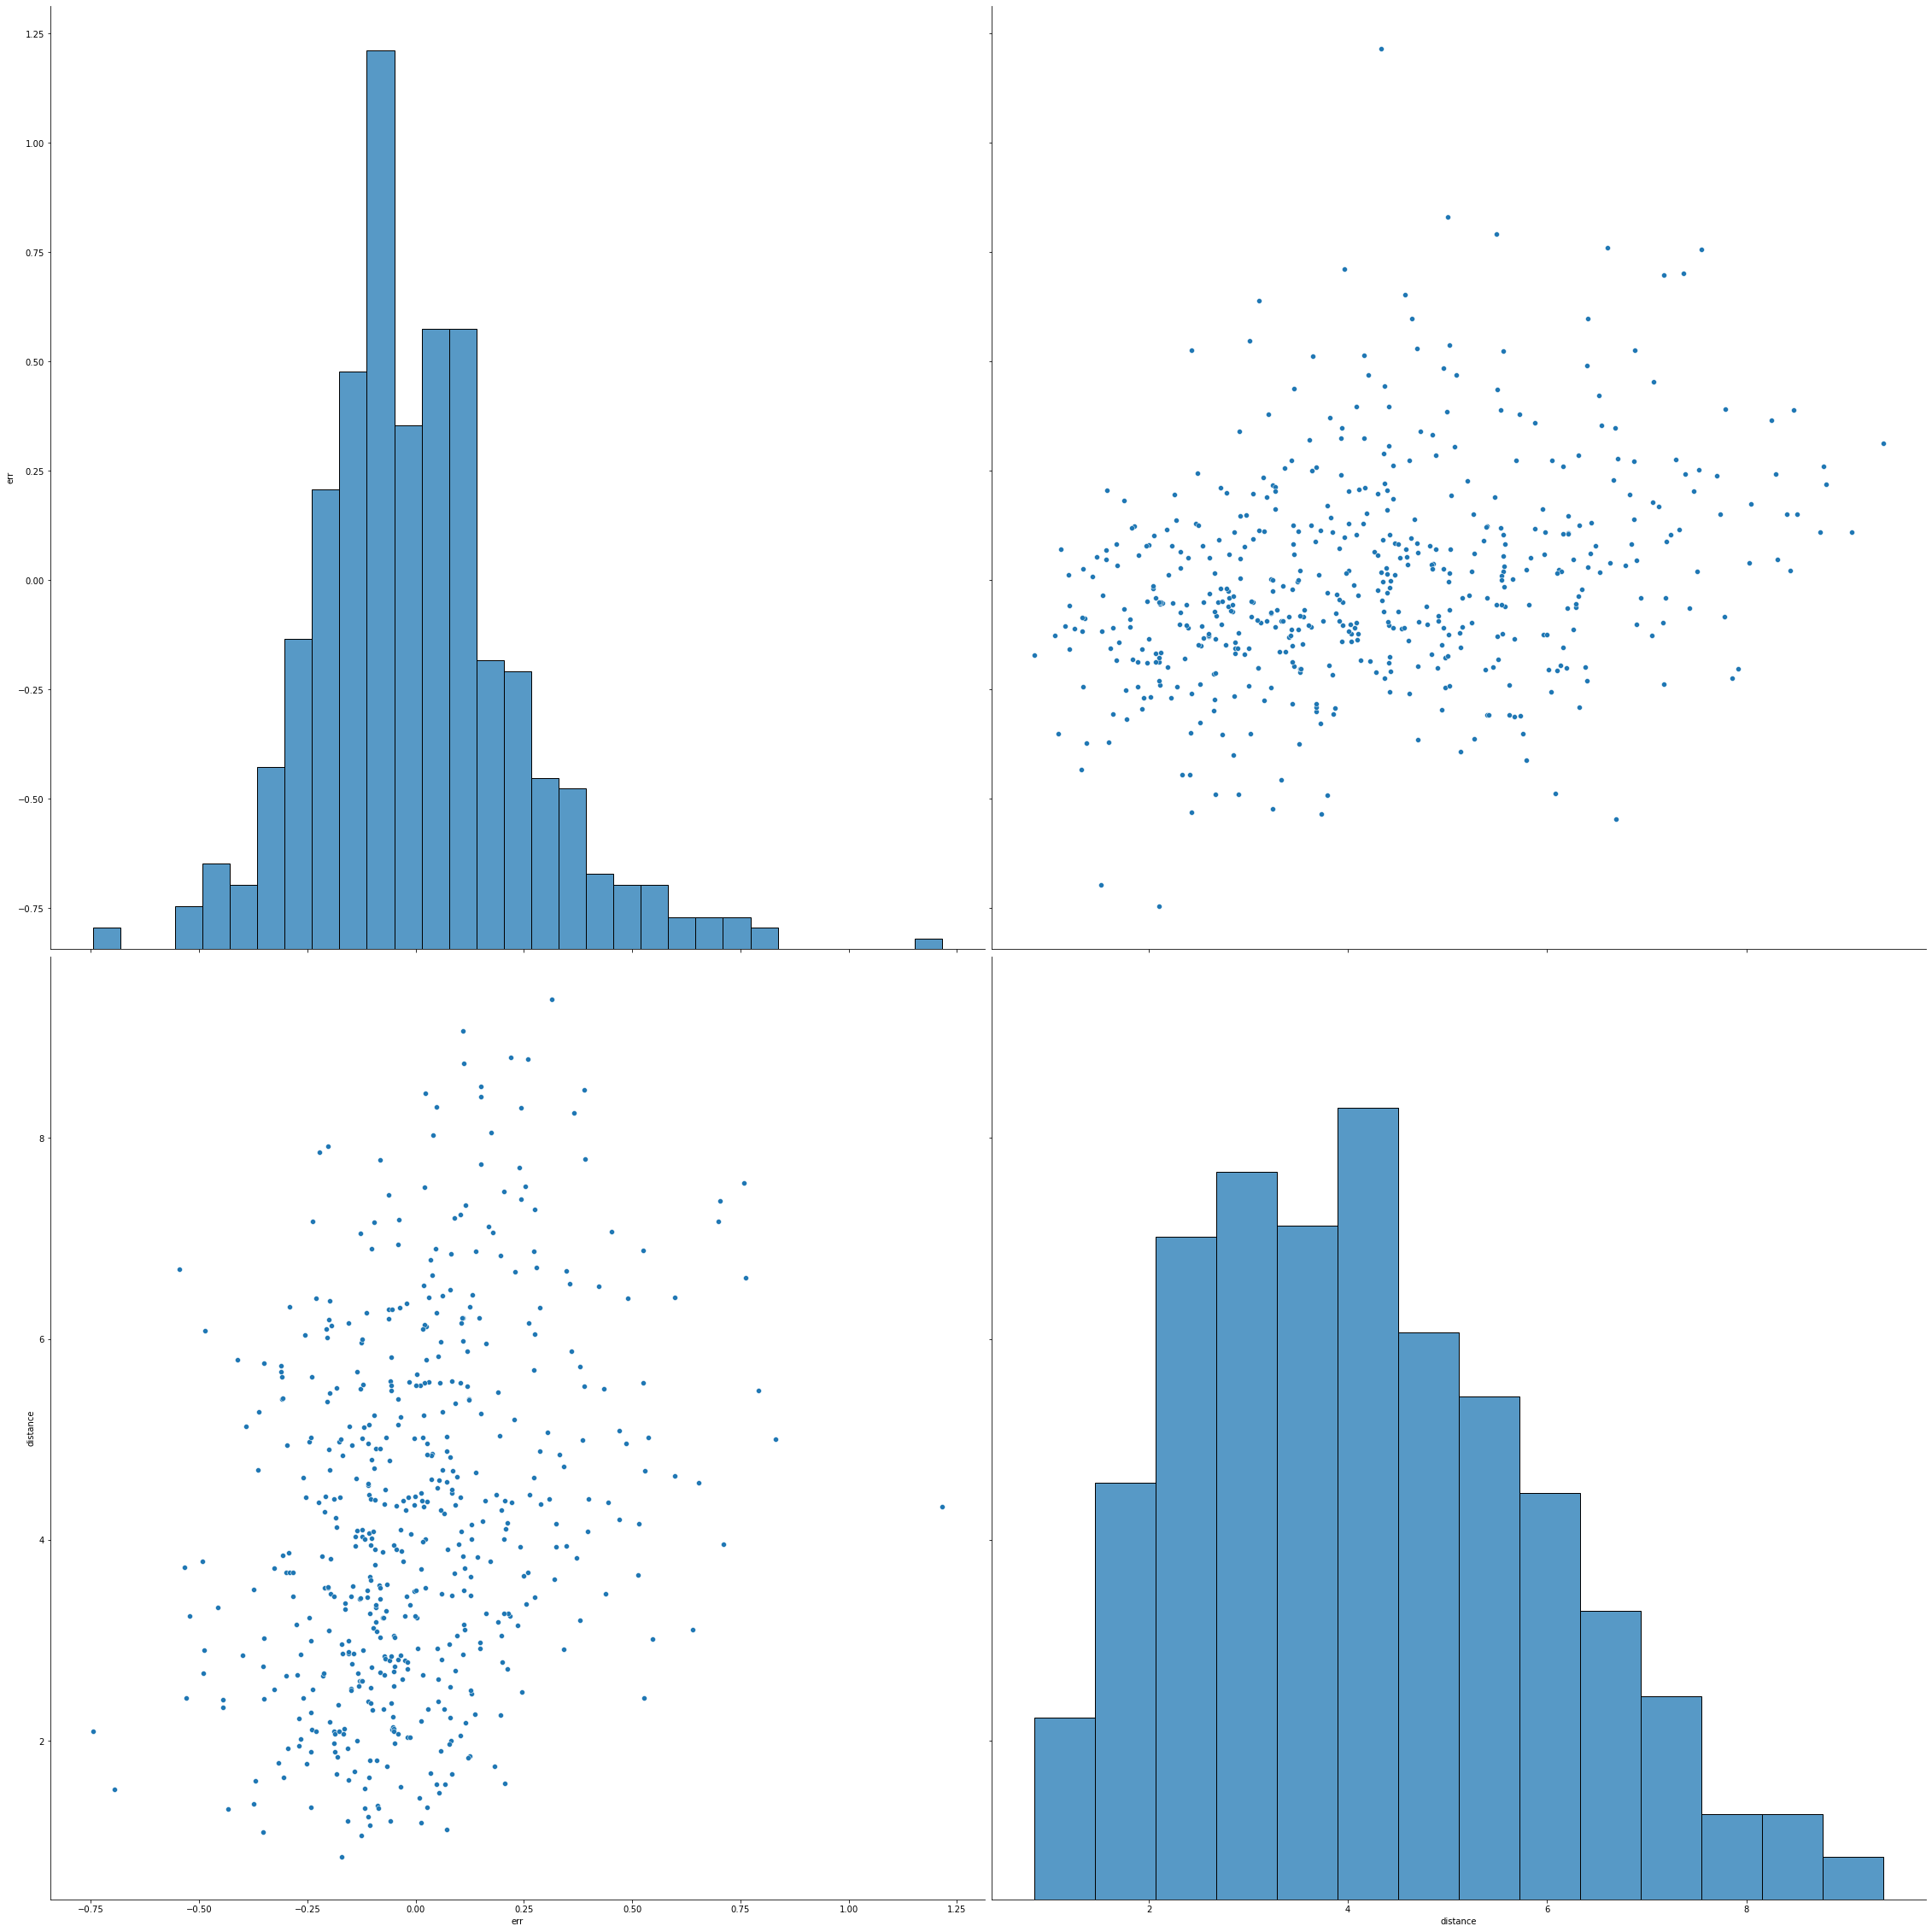

In [15]:
plot_corrc(train_df, ['err'])

In [16]:
#plot_corrc(train_df, ['err_upd'])

Посмотрим на кадры с наибольней (по модулю) ошибкой

In [ ]:
for el in train_df.index[:5]:
    name, x_min, y_min, x_max, y_max, dist, pred, err = train_df.loc[el, ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'distance', 'pred', 'err']].values
    img = open_img(os.path.join(DIR_DATA_TRAIN, name))

    cv2.rectangle(img, 
                  (int(x_min), int(y_min)), 
                  (int(x_max), int(y_max)),
                  (255, 0, 0), 
                  6,
                  #cv2.FILLED
                 )


    img = cv2.resize(img, [252*4, 252*3])

    cv2.imshow('bir error', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()